In [222]:
from pynq import Overlay
import numpy as np
from pynq import allocate
from time import sleep

overlay = Overlay('/home/xilinx/pynq/overlays/final_proj/guitar_effects_design_wrapper.bit')
overlay?

In [223]:
# load in audio file
import wave
import matplotlib.pyplot as plt
from scipy.io import wavfile

file_path = "./electric_guitar_sample.wav"

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    frames = wave_file.readframes(n_frames)
    # convert frames to integers
    frames = np.frombuffer(frames, dtype=np.int16)
    
    # get the frame rate
    frame_rate = wave_file.getframerate()*2 # there are 2 samples per frame, so technically this is sample rate rather than frame rate
    # get the time values for the x axis
    time = np.linspace(0, len(frames) / frame_rate, num=len(frames))
    
#only use the first bit of frames so we can save ourselves some time
length = 1000
frames = frames[:length]
time = time[:length]

In [224]:
# input_buffer = allocate(shape=(len(frames),), dtype=np.int16)
# output_buffer = allocate(shape=(len(frames),), dtype=np.int16)

In [225]:
guitar_effects = overlay.guitar_effects_0
dma = overlay.axi_dma

input = dma.sendchannel
output = dma.recvchannel

In [263]:
# set all inputs and outputs

guitar_effects.register_map.control = 0b1000
guitar_effects.register_map.distortion_threshold = 500
guitar_effects.register_map.distortion_clip_factor = 1.0
guitar_effects.register_map.compression_min_threshold = 200
guitar_effects.register_map.compression_max_threshold = 220
guitar_effects.register_map.zero_threshold = 50
guitar_effects.register_map.delay_mult = 1
guitar_effects.register_map.delay_samples = 1000
print(guitar_effects.register_map)



RegisterMap {
  axilite_out = Register(axilite_out=2),
  axilite_out_ctrl = Register(axilite_out_ap_vld=1, RESERVED=0),
  control = Register(control=write-only, RESERVED=write-only),
  distortion_threshold = Register(distortion_threshold=write-only),
  distortion_clip_factor = Register(distortion_clip_factor=write-only),
  compression_min_threshold = Register(compression_min_threshold=write-only),
  compression_max_threshold = Register(compression_max_threshold=write-only),
  compression_zero_threshold = Register(compression_zero_threshold=write-only),
  delay_mult = Register(delay_mult=write-only),
  delay_samples = Register(delay_samples=write-only)
}


In [264]:
input_buffer = allocate(shape=(len(frames),), dtype=np.int32)
input_buffer[:] = frames

input.transfer(input_buffer)
output_buffer = allocate(shape=(len(frames),), dtype=np.int32)
output.transfer(output_buffer)

0x8


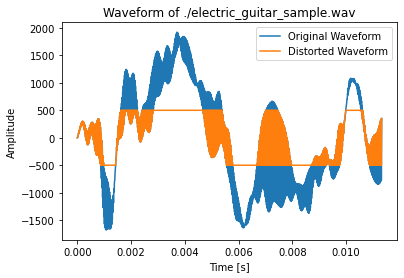

In [265]:
# now plot the output waveform
print(guitar_effects.register_map.axilite_out)

plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, output_buffer, label='Distorted Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()

In [266]:
#save to a wave file
# save frames to .wav file
wavfile.write('outputs/hardware_result.wav', frame_rate, output_buffer)